<a href="https://colab.research.google.com/github/Dylan-Geraci/neuroimaging-tumor-detector/blob/main/notebooks/01_explore_and_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [13]:
# --- Standard library ---
import os
import glob
from collections import defaultdict, Counter
import json

# --- Numerical / data ---
import numpy as np
import pandas as pd

# --- Imaging & plotting ---
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

# --- ML / data loading ---
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms

# --- Colab ---
from google.colab import drive

# --- Utils ---
from tqdm import tqdm

# Set Training Data Path

In [2]:
drive.mount('/content/drive')
TRAIN_PATH = "/content/drive/MyDrive/neuro-imaging/data/Training"

Mounted at /content/drive


# Define Transformations

In [3]:
train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [4]:
base = datasets.ImageFolder(TRAIN_PATH)  # no transform here
y = np.array([label for _, label in base.samples])

# Splitting Data and Training

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(y)), y))

In [6]:
class TransformSubset(Dataset):
    def __init__(self, base_ds, indices, transform):
        self.base = base_ds
        self.indices = indices
        self.transform = transform
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        path, label = self.base.samples[self.indices[i]]
        img = self.base.loader(path)           # PIL image
        if self.transform: img = self.transform(img)
        return img, label

train_ds = TransformSubset(base, train_idx, train_tfms)
val_ds   = TransformSubset(base, val_idx,   val_tfms)

In [7]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [8]:
classes = base.classes
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [9]:
class_counts = {}
for cls in sorted(d for d in os.listdir(TRAIN_PATH) if os.path.isdir(os.path.join(TRAIN_PATH, d))):
    n = len(glob.glob(os.path.join(TRAIN_PATH, cls, "*")))
    class_counts[cls] = n
class_counts

{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}

In [10]:
sizes = []
bad = []
for cls, n in class_counts.items():
    for p in glob.glob(os.path.join(TRAIN_PATH, cls, "*")):
        try:
            with Image.open(p) as im:
                sizes.append((*im.size, cls))  # (W,H,cls)
        except (UnidentifiedImageError, OSError):
            bad.append(p)

print("Corrupt files:", len(bad))
print("Examples:", bad[:3])
ws, hs = zip(*[(w,h) for w,h,_ in sizes])
print("W median/mean:", np.median(ws), np.mean(ws))
print("H median/mean:", np.median(hs), np.mean(hs))

Corrupt files: 0
Examples: []
W median/mean: 512.0 451.563200280112
H median/mean: 512.0 453.8837535014006


## Visualization

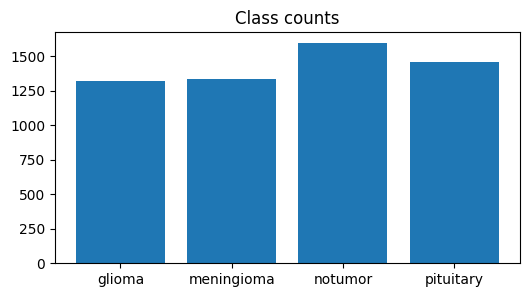

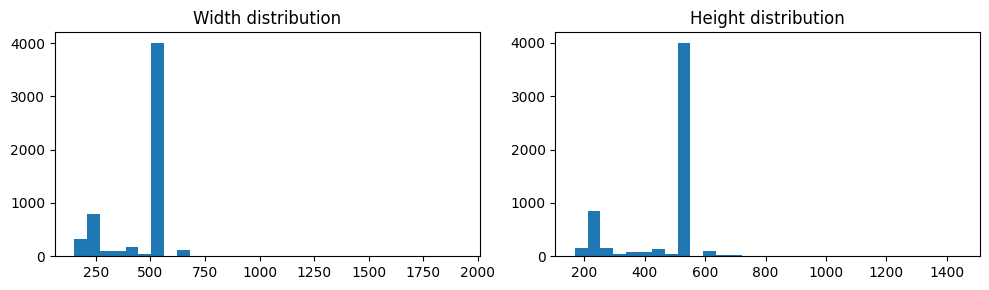

In [11]:
plt.figure(figsize=(6,3))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class counts")
plt.show()

ws, hs = zip(*[(w,h) for w,h,_ in sizes])
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.hist(ws, bins=30); plt.title("Width distribution")
plt.subplot(1,2,2); plt.hist(hs, bins=30); plt.title("Height distribution")
plt.tight_layout(); plt.show()

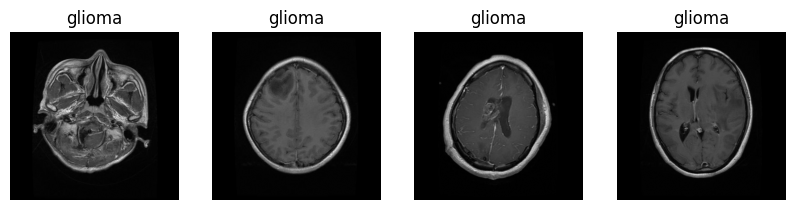

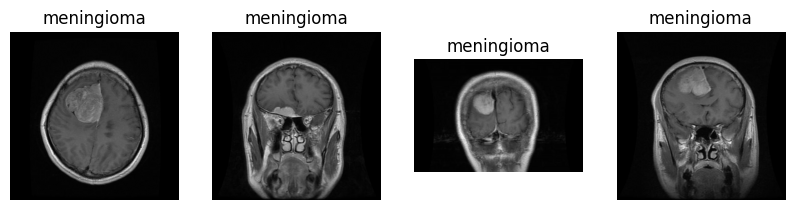

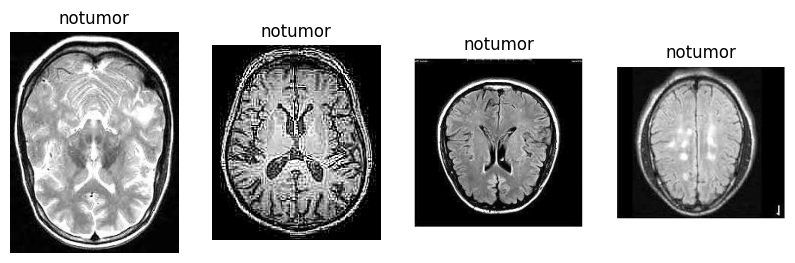

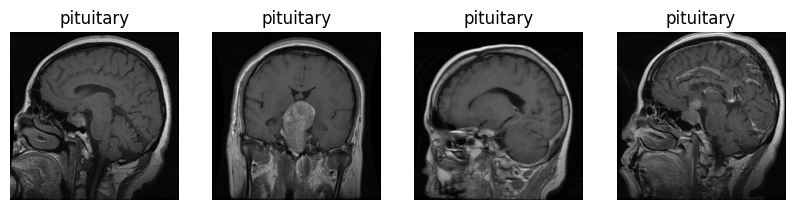

In [ ]:
figsize=(10,3)

for cls in sorted(class_counts):
    paths = glob.glob(os.path.join(TRAIN_PATH, cls, "*"))[:4]
    fig, axs = plt.subplots(1, len(paths), figsize=figsize)
    for ax, p in zip(axs, paths):
        ax.imshow(Image.open(p).convert("L"), cmap="gray")
        ax.set_title(cls); ax.axis("off")
    plt.show()

## Scanning and Altering Data

Scan once and collect paths + sizes + unreadables

In [ ]:
def scan_images(root):
    recs, bad = [], []
    for cls in sorted(d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))):
        for p in glob.glob(os.path.join(root, cls, "*")):
            try:
                with Image.open(p) as im:
                    w, h = im.size
                recs.append({"path": p, "cls": cls, "w": w, "h": h})
            except (UnidentifiedImageError, OSError) as e:
                bad.append({"path": p, "cls": cls, "error": repr(e)})
    return pd.DataFrame(recs), pd.DataFrame(bad)

df, bad_df = scan_images(TRAIN_PATH)
print(f"Readable images: {len(df)}  |  Unreadable: {len(bad_df)}")
bad_df.head(5)

Readable images: 5712  |  Unreadable: 0


""


Checking for smaller images through a range (can be applied to other image projects)

In [ ]:
mins = np.array([min(w,h) for (w,h,_) in sizes])
df_sizes = pd.DataFrame([{"cls": c, "min_side": min(w,h)} for (w,h,c) in sizes])

for thr in [64, 80, 96, 112]:
    flagged = df_sizes["min_side"] < thr
    print(f"thr={thr}: flag {flagged.mean():.1%} of images")
    print(df_sizes[flagged].groupby("cls").size(), "\n")

thr=64: flag 0.0% of images
Series([], dtype: int64) 

thr=80: flag 0.0% of images
Series([], dtype: int64) 

thr=96: flag 0.0% of images
Series([], dtype: int64) 

thr=112: flag 0.0% of images
Series([], dtype: int64) 



## Split Creation

In [15]:
SPLITS_DIR = "/content/drive/MyDrive/neuro-imaging/splits"
os.makedirs(SPLITS_DIR, exist_ok=True)

class_to_idx = base.class_to_idx
with open(os.path.join(SPLITS_DIR, "class_to_idx.json"), "w") as f:
    json.dump(class_to_idx, f, indent=2)

def _write_paths(paths, out_path):
    with open(out_path, "w") as f:
        for p in paths:
            f.write(os.path.abspath(p) + "\n")

train_paths = [base.samples[i][0] for i in train_idx]
val_paths   = [base.samples[i][0] for i in val_idx]

_write_paths(train_paths, os.path.join(SPLITS_DIR, "train.txt"))
_write_paths(val_paths,   os.path.join(SPLITS_DIR, "val.txt"))

assert set(train_paths).isdisjoint(set(val_paths)), "Overlap between train/val splits."
print(f"Saved: {len(train_paths)} train, {len(val_paths)} val")

idx_to_class = {v:k for k,v in class_to_idx.items()}
train_counts = Counter([os.path.basename(os.path.dirname(p)) for p in train_paths])
print("Train split class counts:", {c: train_counts[c] for c in class_to_idx})

Saved: 4855 train, 857 val
Train split class counts: {'glioma': 1123, 'meningioma': 1138, 'notumor': 1356, 'pituitary': 1238}
